In [1]:
! pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fid = drive.ListFile({'q':"title='multi_ct.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('multi_ct.zip')

In [8]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [9]:
!unzip multi_ct.zip

Archive:  multi_ct.zip
   creating: multi_ct/
   creating: multi_ct/test/
   creating: multi_ct/test/covid-19/
  inflating: multi_ct/test/covid-19/pCT1.jpg  
  inflating: multi_ct/test/covid-19/pCT10.jpg  
  inflating: multi_ct/test/covid-19/pCT100.jpg  
  inflating: multi_ct/test/covid-19/pCT101.jpg  
  inflating: multi_ct/test/covid-19/pCT102.jpg  
  inflating: multi_ct/test/covid-19/pCT103.jpg  
  inflating: multi_ct/test/covid-19/pCT104.jpg  
  inflating: multi_ct/test/covid-19/pCT105.jpg  
  inflating: multi_ct/test/covid-19/pCT106.jpg  
  inflating: multi_ct/test/covid-19/pCT107.jpg  
  inflating: multi_ct/test/covid-19/pCT108.jpg  
  inflating: multi_ct/test/covid-19/pCT109.jpg  
  inflating: multi_ct/test/covid-19/pCT11.jpg  
  inflating: multi_ct/test/covid-19/pCT110.jpg  
  inflating: multi_ct/test/covid-19/pCT111.jpg  
  inflating: multi_ct/test/covid-19/pCT112.jpg  
  inflating: multi_ct/test/covid-19/pCT113.jpg  
  inflating: multi_ct/test/covid-19/pCT114.jpg  
  inflating

In [10]:
train_path = "/content/multi_ct/train"
test_path = "/content/multi_ct/test"

In [11]:
PATH = '/content/multi_ct'
os.listdir(PATH)
train_dir = os.path.join(PATH,
                         'train')
test_dir = os.path.join(PATH,
                        'test')
train_normal_dir = os.path.join(train_dir,
                                'normal')
train_covid19_dir = os.path.join(train_dir,
                               'covid-19')

test_normal_dir = os.path.join(test_dir,
                               'normal')
test_covid19_dir = os.path.join(test_dir,
                              'covid-19')
len(os.listdir(train_normal_dir))


500

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=20,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = False,
 channel_shift_range = 20,
 horizontal_flip = False ,
 vertical_flip = False ,
 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 1500 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


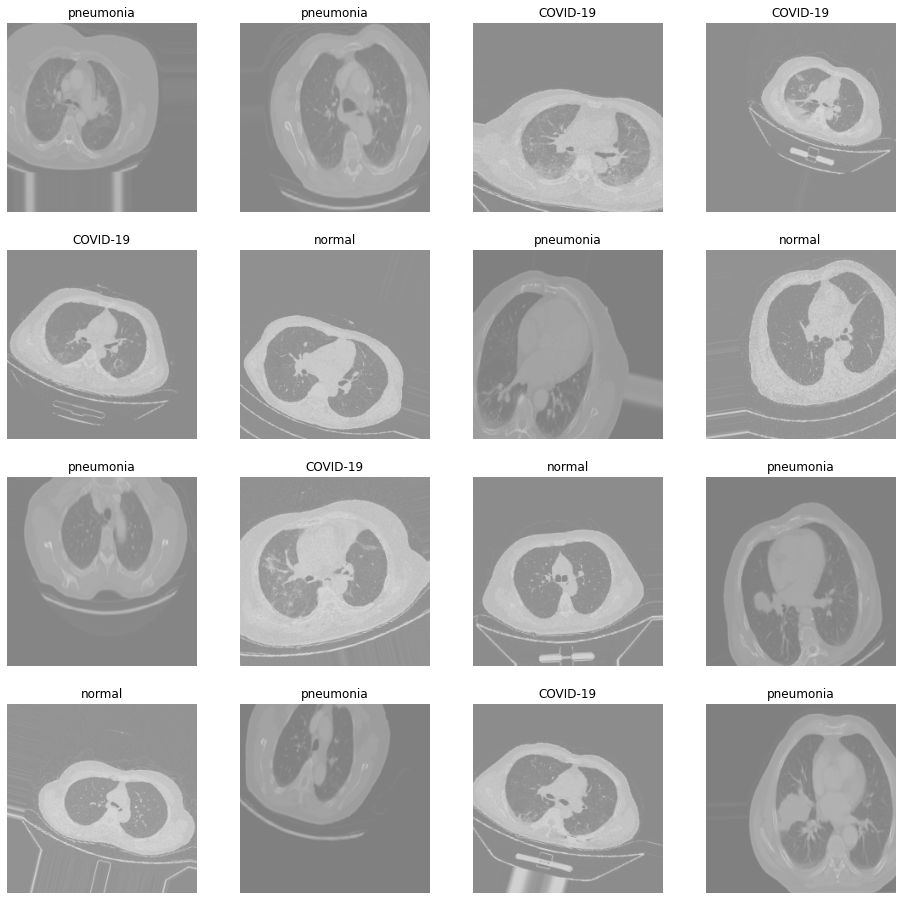

In [15]:
all_labels = ['COVID-19','normal', 'pneumonia']
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [16]:
from keras.applications import ResNet50
resModel = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
outputs = resModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(3, activation="softmax")(outputs)

model = Model(inputs=resModel.input, outputs=outputs)

for layer in resModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [18]:
epochs= 100

BS = 16

In [19]:
#history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=BS),steps_per_epoch=len(X_train) // BS,validation_data=(X_test, Y_test),validation_steps=len(X_test) // BS,epochs=epochs)
model.fit_generator(train_generator,
                    steps_per_epoch = 318//BS,
                    epochs = epochs,
                    validation_data = test_generator,
                    validation_steps = 48//BS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
19/19 [==============================] - 15s 324ms/step - loss: 3.7231 - accuracy: 0.5050 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/100
19/19 [==============================] - 5s 264ms/step - loss: 1.7008 - accuracy: 0.6413 - val_loss: 0.4466 - val_accuracy: 0.6667
Epoch 3/100
19/19 [==============================] - 5s 262ms/step - loss: 1.5592 - accuracy: 0.6668 - val_loss: 7.5840 - val_accuracy: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 5s 263ms/step - loss: 0.8397 - accuracy: 0.7265 - val_loss: 6.8687 - val_accuracy: 0.0000e+00
Epoch 5/100
19/19 [==============================] - 5s 263ms/step - loss: 0.7283 - accuracy: 0.7999 - val_loss: 0.5055 - val_accuracy: 0.6667
Epoch 6/100
19/19 [==============================] - 5s 263ms/step - loss: 1.0316 - accuracy: 0.7405 - val_loss: 1.0892 - val_accuracy: 0.6667
Epoch 7/100
19/19 [==============================] - 5s 265ms/step - loss: 0.8981 - accuracy: 0.7901 - val_loss: 1.1574 - val_accurac

In [20]:
x = model.evaluate_generator(test_generator,
 steps = np.ceil(len(test_generator) // BS),
 use_multiprocessing = False,
 verbose = 1,
 workers=1
 )

 8/28 [=======>......................] - ETA: 0s - loss: 3.8531 - accuracy: 0.5000

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


28/28 [==============================] - 0s 13ms/step - loss: 2.5779 - accuracy: 0.6429


In [21]:
from keras.callbacks import History 
history = History()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


30/30 [==============================] - 1s 13ms/step
Predictions finished
prob:[9.759453e-06 9.999896e-01 6.074394e-07]
covid-19/pCT1.jpg


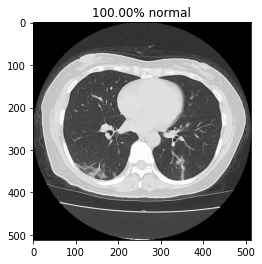

prob:[3.1652082e-08 9.9998975e-01 1.0232211e-05]
covid-19/pCT10.jpg


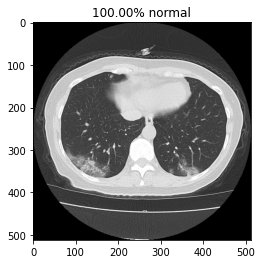

prob:[3.7997833e-01 6.2002170e-01 9.6987457e-20]
covid-19/pCT100.jpg


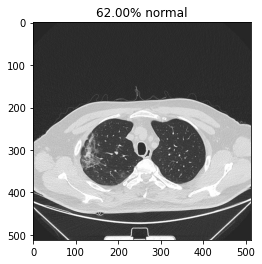

prob:[8.7066317e-01 1.2933683e-01 2.8140004e-11]
covid-19/pCT101.jpg


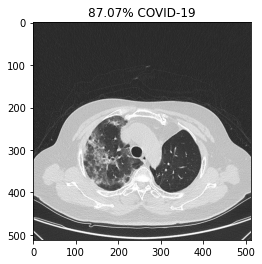

prob:[9.9792409e-01 2.0758477e-03 9.8906416e-22]
covid-19/pCT102.jpg


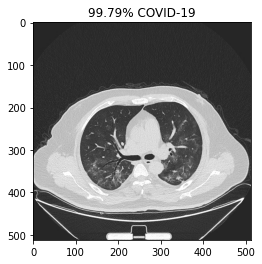

prob:[9.9948454e-01 5.1548064e-04 7.3860492e-19]
covid-19/pCT103.jpg


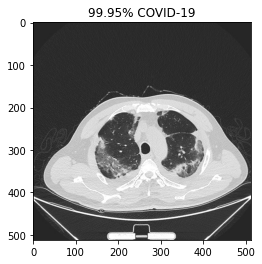

prob:[4.9386173e-01 5.0613827e-01 2.5879871e-20]
covid-19/pCT104.jpg


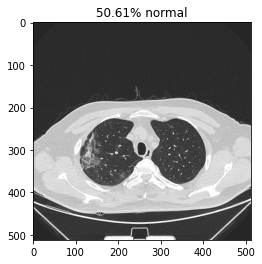

prob:[8.1477636e-01 1.8522367e-01 5.5930499e-12]
covid-19/pCT105.jpg


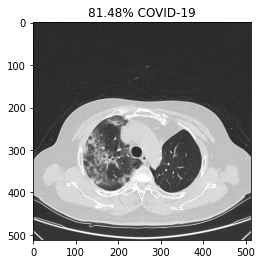

prob:[9.9878818e-01 1.2118234e-03 1.7060439e-21]
covid-19/pCT106.jpg


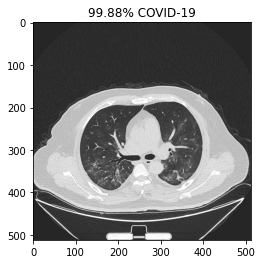

prob:[9.9919611e-01 8.0386526e-04 2.0477275e-19]
covid-19/pCT107.jpg


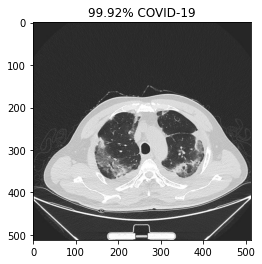

prob:[4.6663502e-01 5.3336495e-01 9.0727165e-21]
covid-19/pCT108.jpg


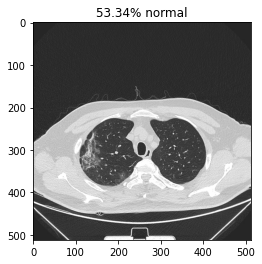

prob:[8.5318881e-01 1.4681114e-01 2.2607560e-12]
covid-19/pCT109.jpg


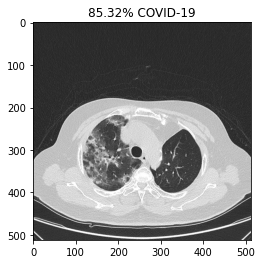

prob:[1.5860184e-08 9.9999952e-01 4.2989220e-07]
covid-19/pCT11.jpg


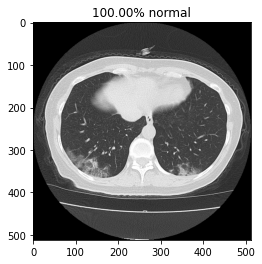

prob:[9.9851984e-01 1.4801379e-03 2.0304459e-21]
covid-19/pCT110.jpg


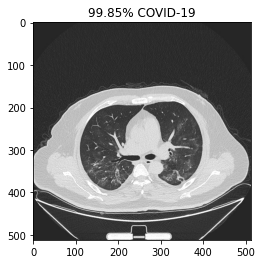

prob:[9.9893576e-01 1.0642173e-03 1.3613240e-19]
covid-19/pCT111.jpg


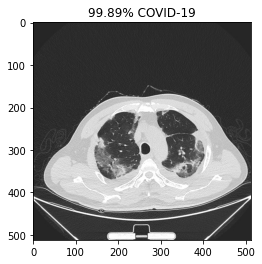

prob:[3.9179265e-01 6.0820735e-01 1.5662626e-20]
covid-19/pCT112.jpg


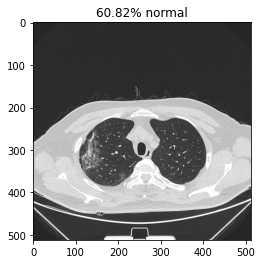

prob:[9.0172762e-01 9.8272339e-02 4.4298645e-12]
covid-19/pCT113.jpg


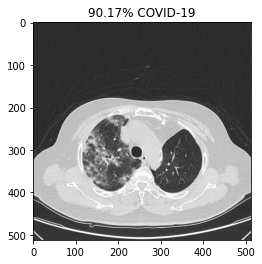

prob:[9.9852282e-01 1.4772366e-03 6.8330440e-22]
covid-19/pCT114.jpg


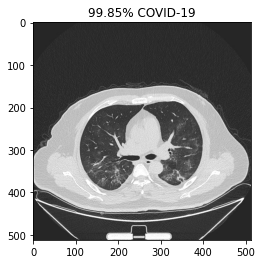

prob:[9.9887544e-01 1.1245711e-03 1.5216199e-18]
covid-19/pCT115.jpg


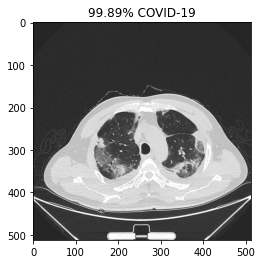

prob:[3.7452883e-01 6.2547117e-01 4.1303044e-20]
covid-19/pCT116.jpg


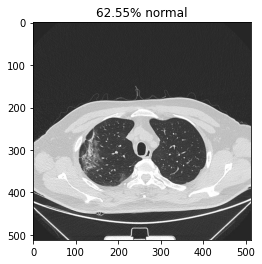

prob:[9.358865e-01 6.411348e-02 5.693713e-12]
covid-19/pCT117.jpg


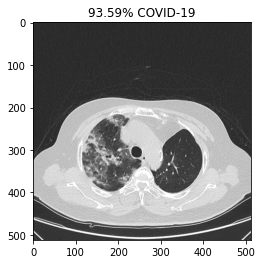

prob:[9.9818569e-01 1.8142271e-03 1.2766318e-21]
covid-19/pCT118.jpg


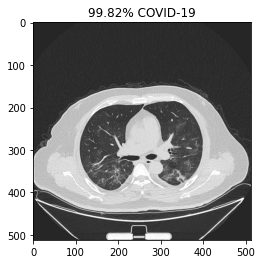

prob:[9.9884856e-01 1.1514089e-03 2.1646219e-18]
covid-19/pCT119.jpg


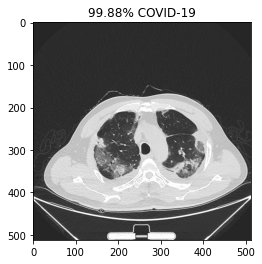

prob:[5.0664135e-09 9.9999905e-01 9.4275509e-07]
covid-19/pCT12.jpg


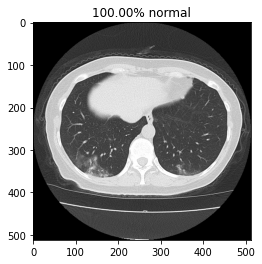

prob:[2.980696e-01 7.019304e-01 4.420058e-20]
covid-19/pCT120.jpg


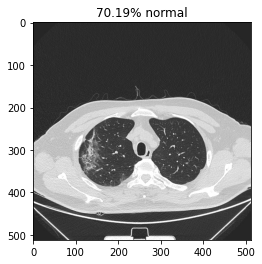

prob:[9.452771e-01 5.472292e-02 8.909305e-12]
covid-19/pCT121.jpg


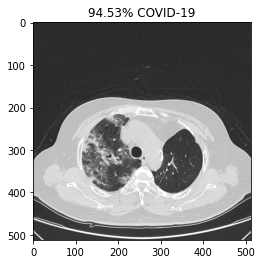

prob:[9.9022549e-01 9.7745480e-03 2.9433514e-21]
covid-19/pCT122.jpg


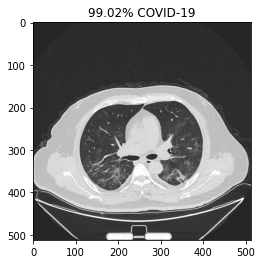

prob:[9.9928623e-01 7.1383483e-04 1.0943263e-18]
covid-19/pCT123.jpg


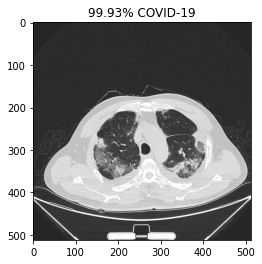

prob:[2.27954537e-01 7.72045493e-01 1.07402565e-19]
covid-19/pCT124.jpg


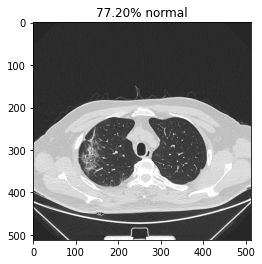

prob:[9.7717530e-01 2.2824682e-02 2.4944482e-11]
covid-19/pCT125.jpg


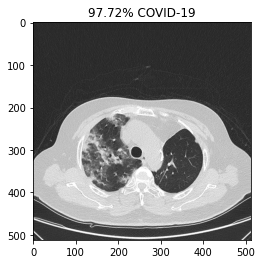

In [22]:
#eval_generator.reset() 
pred = model.predict_generator(test_generator,30,verbose=1)
print("Predictions finished")
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
 image_path = test_path + "/" +test_generator.filenames[index]
 image = mpimg.imread(image_path)
 #BGR TO RGB conversion using CV2
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 pixels = np.array(image)
 plt.imshow(pixels)
 print("prob:{}".format(probability))
 print(test_generator.filenames[index])
 if probability[1] > 0.5:
     plt.title('%.2f' % (probability[1]*100) + '% normal')
 else:
     plt.title('%.2f' % ((1-probability[1])*100) + '% COVID-19')
 plt.show()

In [23]:
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Test loss: 2.5779309272766113
Test accuracy: 0.6428571343421936


In [24]:
import keras
from keras.models import load_model
model.save('resnet50_model_95.h5')
model_ = tf.keras.models.load_model('resnet50_model_95.h5')

In [26]:
image_test = Image.open("/content/multi_ct/train/covid-19/pCT951.jpg").convert('RGB')
image_test = image_test.resize((224,224))
data_test = np.asarray(image_test)
img = np.reshape(data_test,[1,224,224,3])

[[0.0, 1.0, 0.0]]

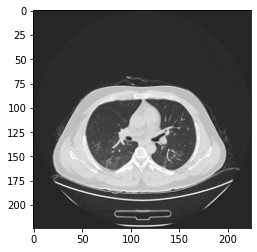

In [27]:
plt.imshow(image_test)
model_.predict(img).tolist()

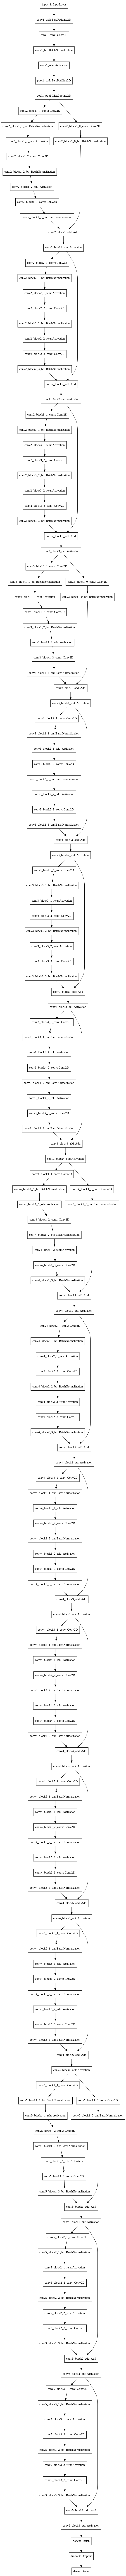

In [28]:
from keras.utils import plot_model
plot_model(model_, to_file='model.png')

In [29]:
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
Y_pred = model_.predict_generator(test_generator, np.ceil(len(test_generator) ))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [30]:
y_pred = np.argmax(Y_pred, axis=1)

In [31]:
print(confusion_matrix(test_generator.classes, y_pred))


[[122  28   0]
 [  6 144   0]
 [  0   0 150]]


In [32]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for COVID-19 classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

ValueError: ignored

In [ ]:
plt.hist(y_pred, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of COVID-19')
plt.ylabel('Frequency')

In [34]:
print('Classification Report')
target_names = ['COVID-19','normal', 'pneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    COVID-19       0.95      0.81      0.88       150
      normal       0.84      0.96      0.89       150
   pneumonia       1.00      1.00      1.00       150

    accuracy                           0.92       450
   macro avg       0.93      0.92      0.92       450
weighted avg       0.93      0.92      0.92       450



In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=y_pred)
cm_plot_labels= ['COVID-19','normal']

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')